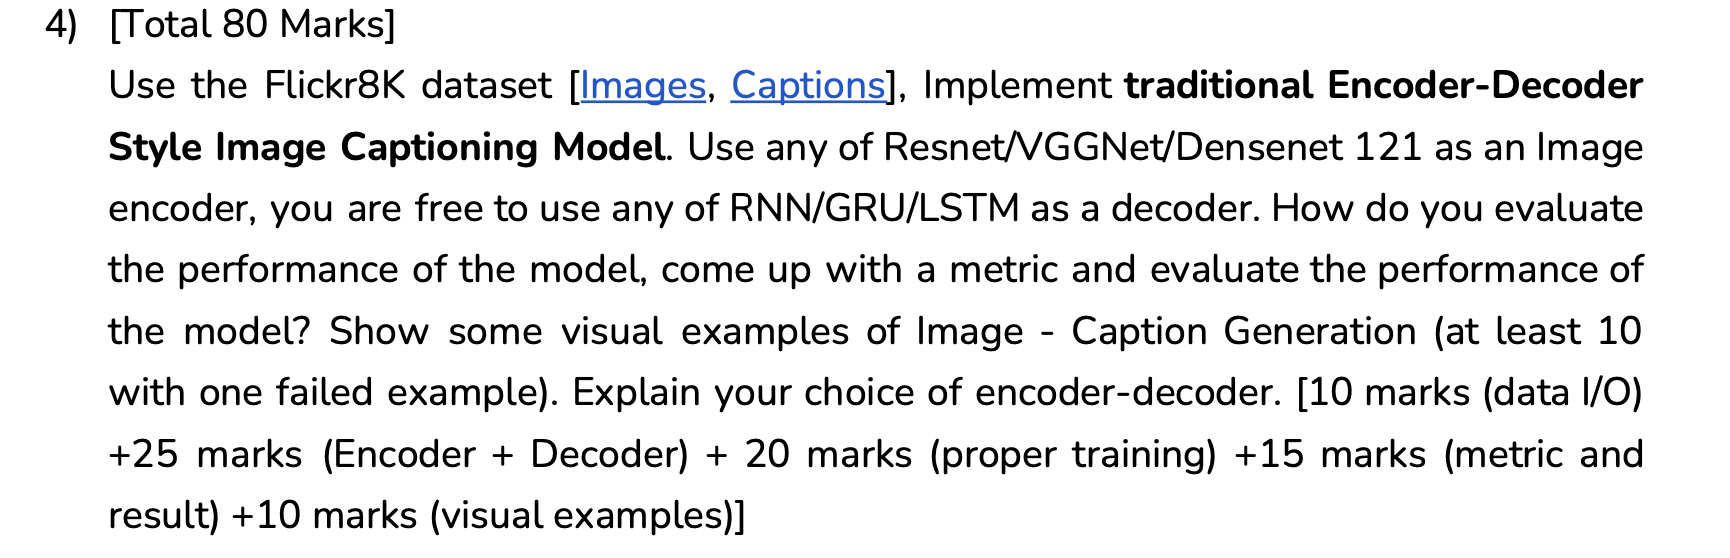

https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip


https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip

In [1]:

api_token = {"username":"samy280497","key":"f80239517ec84712358a021a2389ffc4"}


In [2]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json


import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
!kaggle datasets download -d aladdinpersson/flickr8kimagescaptions

flickr8kimagescaptions.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!ls

flickr8k		    __pycache__  sample_data	utils.py
flickr8kimagescaptions.zip  runs	 test_examples


In [5]:
!unzip flickr8kimagescaptions.zip

Archive:  flickr8kimagescaptions.zip
replace flickr8k/captions.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
# num_epochs = 20
import os  # when loading file paths
import pandas as pd  # for lookup in annotation file
import spacy  # for tokenizer
import torch
from torch.nn.utils.rnn import pad_sequence  # pad batch
from torch.utils.data import DataLoader, Dataset
from PIL import Image  # Load img
import torchvision.transforms as transforms


# We want to convert text -> numerical values
# 1. We need a Vocabulary mapping each word to a index
# 2. We need to setup a Pytorch dataset to load the data
# 3. Setup padding of every batch (all examples should be
#    of same seq_len and setup dataloader)
# Note that loading the image is very easy compared to the text!

# Download with: python -m spacy download en
spacy_eng = spacy.load("en")


class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]


class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform

        # Get img, caption columns
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]

        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(numericalized_caption)


class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        return imgs, targets


def get_loader(
    root_folder,
    annotation_file,
    transform,
    batch_size=32,
    num_workers=8,
    shuffle=True,
    pin_memory=True,
):
    dataset = FlickrDataset(root_folder, annotation_file, transform=transform)

    pad_idx = dataset.vocab.stoi["<PAD>"]

    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx),
    )

    return loader, dataset



# transform = transforms.Compose(
#     [transforms.Resize((224, 224)), transforms.ToTensor(),]
# )

# loader, dataset = get_loader(
#     "flickr8k/images/", "flickr8k/captions.txt", transform=transform
# )

    # for idx, (imgs, captions) in enumerate(loader):
    #     print(imgs.shape)
    #     print(captions.shape)




import torch
import torch.nn as nn
import statistics
import torchvision.models as models


class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        self.train_CNN = train_CNN
        self.inception = models.inception_v3(pretrained=True, aux_logits=False)
        self.inception.fc = nn.Linear(self.inception.fc.in_features, embed_size)
        self.relu = nn.ReLU()
        self.times = []
        self.dropout = nn.Dropout(0.5)

    def forward(self, images):
        features = self.inception(images)
        return self.dropout(self.relu(features))


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs


class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length=50):
        result_caption = []

        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None

            for _ in range(max_length):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)
                result_caption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0)

                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break

        return [vocabulary.itos[idx] for idx in result_caption]
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from utils import save_checkpoint, load_checkpoint, print_examples
# from get_loader import get_loader
# from model import CNNtoRNN


def train():
    transform = transforms.Compose(
        [
            transforms.Resize((356, 356)),
            transforms.RandomCrop((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    train_loader, dataset = get_loader(
        root_folder="flickr8k/images",
        annotation_file="flickr8k/captions.txt",
        transform=transform,
        num_workers=2,
    )

    torch.backends.cudnn.benchmark = True
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    load_model = False
    save_model = False
    train_CNN = False

    # Hyperparameters
    embed_size = 256
    hidden_size = 256
    vocab_size = len(dataset.vocab)
    num_layers = 1
    learning_rate = 3e-4
    num_epochs = 20

    # for tensorboard
    writer = SummaryWriter("runs/flickr")
    step = 0

    # initialize model, loss etc
    model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Only finetune the CNN
    for name, param in model.encoderCNN.inception.named_parameters():
        if "fc.weight" in name or "fc.bias" in name:
            param.requires_grad = True
        else:
            param.requires_grad = train_CNN

    if load_model:
        step = load_checkpoint(torch.load("my_checkpoint.pth.tar"), model, optimizer)

    model.train()

    for epoch in range(num_epochs):
        # Uncomment the line below to see a couple of test cases
        print_examples(model, device, dataset)

        if save_model:
            checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "step": step,
            }
            save_checkpoint(checkpoint)

        for idx, (imgs, captions) in tqdm(
            enumerate(train_loader), total=len(train_loader), leave=False
        ):
            imgs = imgs.to(device)
            captions = captions.to(device)

            outputs = model(imgs, captions[:-1])
            loss = criterion(
                outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
            )

            writer.add_scalar("Training loss", loss.item(), global_step=step)
            step += 1

            optimizer.zero_grad()
            loss.backward(loss)
            optimizer.step()


if __name__ == "__main__":
    train()

Example 1 CORRECT: Man in red jacket
Example 1 OUTPUT: campsite cobblestone lies int defenders shooting cow balloon guys vehicle drive boats rests sash monitor we crystal tinkerbell mountaineer crowd special legos bikini canopy ridge seaweed tinkerbell dance gun turns battle shot was hits guys guys vehicle paddle makes greyhounds stars trashcan pink towel foot spiky terriers rides arms box
Example 2 CORRECT: Elephent in grass
Example 2 OUTPUT: surfboard against stools passing amusement fireman cheerleaders built skateboarder headfirst grab hopping defenders hovering boats church rowboat karate waves stores parasail & guitars flower hopping overhead awning church church joy fairy mountaintop mountaintop hoodie retriever pacifier surfboarder boxers fellow lay rocky among teal overweight bricks sprays lamp lamp yard this
Example 3 CORRECT: bears playing on stones
Example 3 OUTPUT: against mother flaps style peanut bags posing mat teenager hurdle shirtless tattoo preparing farm smelling ch

Example 1 CORRECT: Man in red jacket
Example 1 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
Example 2 CORRECT: Elephent in grass
Example 2 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
Example 3 CORRECT: bears playing on stones
Example 3 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
Example 4 CORRECT: A parked bus
Example 4 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
Example 5 CORRECT: A red car on road
Example 5 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>


Example 1 CORRECT: Man in red jacket
Example 1 OUTPUT: <SOS> a man in a red shirt is standing on a skateboard . <EOS>
Example 2 CORRECT: Elephent in grass
Example 2 OUTPUT: <SOS> a man in a red shirt is standing on a skateboard . <EOS>
Example 3 CORRECT: bears playing on stones
Example 3 OUTPUT: <SOS> a man in a red shirt is standing on a skateboard . <EOS>
Example 4 CORRECT: A parked bus
Example 4 OUTPUT: <SOS> a man in a red shirt is standing on a skateboard . <EOS>
Example 5 CORRECT: A red car on road
Example 5 OUTPUT: <SOS> a man in a red shirt is standing on a skateboard . <EOS>


Example 1 CORRECT: Man in red jacket
Example 1 OUTPUT: <SOS> a man in a blue shirt is standing on a bench . <EOS>
Example 2 CORRECT: Elephent in grass
Example 2 OUTPUT: <SOS> a man in a blue shirt is standing on a bench . <EOS>
Example 3 CORRECT: bears playing on stones
Example 3 OUTPUT: <SOS> a dog is running through the grass . <EOS>
Example 4 CORRECT: A parked bus
Example 4 OUTPUT: <SOS> a man in a blue shirt is standing on a bench . <EOS>
Example 5 CORRECT: A red car on road
Example 5 OUTPUT: <SOS> a man in a blue shirt is standing on a bench . <EOS>


Example 1 CORRECT: Man in red jacket
Example 1 OUTPUT: <SOS> a man in a red shirt is standing on a bench . <EOS>
Example 2 CORRECT: Elephent in grass
Example 2 OUTPUT: <SOS> a man in a red shirt is standing on a bench . <EOS>
Example 3 CORRECT: bears playing on stones
Example 3 OUTPUT: <SOS> a dog is running through the grass . <EOS>
Example 4 CORRECT: A parked bus
Example 4 OUTPUT: <SOS> a man in a red shirt is standing on a bench . <EOS>
Example 5 CORRECT: A red car on road
Example 5 OUTPUT: <SOS> a man in a red shirt is standing on a rock wall . <EOS>


Example 1 CORRECT: Man in red jacket
Example 1 OUTPUT: <SOS> a man in a blue shirt and a black hat is standing on a rock . <EOS>
Example 2 CORRECT: Elephent in grass
Example 2 OUTPUT: <SOS> a man in a red shirt and a black hat is standing on a bench . <EOS>
Example 3 CORRECT: bears playing on stones
Example 3 OUTPUT: <SOS> a dog is running through the grass . <EOS>
Example 4 CORRECT: A parked bus
Example 4 OUTPUT: <SOS> a man in a red shirt and a black hat is standing on a bench . <EOS>
Example 5 CORRECT: A red car on road
Example 5 OUTPUT: <SOS> a man in a red shirt is riding a bike on a dirt bike . <EOS>


Example 1 CORRECT: Man in red jacket
Example 1 OUTPUT: <SOS> a man in a blue shirt and a black hat is standing on a rock . <EOS>
Example 2 CORRECT: Elephent in grass
Example 2 OUTPUT: <SOS> a man in a blue shirt and a woman in a black shirt and a woman in a black shirt and a woman in a black shirt and a woman in a black shirt and a woman in a black shirt and a woman are sitting on a bench
Example 3 CORRECT: bears playing on stones
Example 3 OUTPUT: <SOS> a dog is running through the snow . <EOS>
Example 4 CORRECT: A parked bus
Example 4 OUTPUT: <SOS> a man in a blue shirt and a black hat is standing on a bench . <EOS>
Example 5 CORRECT: A red car on road
Example 5 OUTPUT: <SOS> a man in a blue shirt is riding a bike on a dirt bike . <EOS>


Example 1 CORRECT: Man in red jacket
Example 1 OUTPUT: <SOS> a man in a red shirt is standing on a rock in front of a building . <EOS>
Example 2 CORRECT: Elephent in grass
Example 2 OUTPUT: <SOS> a man in a red shirt is standing in front of a building . <EOS>
Example 3 CORRECT: bears playing on stones
Example 3 OUTPUT: <SOS> a dog is running through the snow . <EOS>
Example 4 CORRECT: A parked bus
Example 4 OUTPUT: <SOS> a man in a red shirt is standing on a bench with a woman in a black shirt . <EOS>
Example 5 CORRECT: A red car on road
Example 5 OUTPUT: <SOS> a man in a red shirt is riding a bike in a race . <EOS>


Example 1 CORRECT: Man in red jacket
Example 1 OUTPUT: <SOS> a man in a black jacket is standing on a rock overlooking a rocky beach . <EOS>
Example 2 CORRECT: Elephent in grass
Example 2 OUTPUT: <SOS> a man in a blue shirt is standing in front of a building . <EOS>
Example 3 CORRECT: bears playing on stones
Example 3 OUTPUT: <SOS> a dog is running through the snow . <EOS>
Example 4 CORRECT: A parked bus
Example 4 OUTPUT: <SOS> a group of people are gathered around a <UNK> . <EOS>
Example 5 CORRECT: A red car on road
Example 5 OUTPUT: <SOS> a man in a red shirt is riding a bike on a dirt road . <EOS>


Example 1 CORRECT: Man in red jacket
Example 1 OUTPUT: <SOS> a man in a blue shirt and a black hat is standing on a rock . <EOS>
Example 2 CORRECT: Elephent in grass
Example 2 OUTPUT: <SOS> a man in a red shirt is standing on a bench with a woman in a black jacket . <EOS>
Example 3 CORRECT: bears playing on stones
Example 3 OUTPUT: <SOS> a dog is running through the grass . <EOS>
Example 4 CORRECT: A parked bus
Example 4 OUTPUT: <SOS> a man in a red shirt is standing on a bench with a woman in a black jacket . <EOS>
Example 5 CORRECT: A red car on road
Example 5 OUTPUT: <SOS> a man is riding a bike on a dirt road . <EOS>


Example 1 CORRECT: Man in red jacket
Example 1 OUTPUT: <SOS> a man in a black shirt and a black shirt is standing on a rock . <EOS>
Example 2 CORRECT: Elephent in grass
Example 2 OUTPUT: <SOS> a man in a red shirt is standing on a sidewalk . <EOS>
Example 3 CORRECT: bears playing on stones
Example 3 OUTPUT: <SOS> a dog is running through the grass . <EOS>
Example 4 CORRECT: A parked bus
Example 4 OUTPUT: <SOS> a man in a red shirt is standing on a sidewalk . <EOS>
Example 5 CORRECT: A red car on road
Example 5 OUTPUT: <SOS> a man in a red shirt is riding a bicycle on a dirt road . <EOS>


Example 1 CORRECT: Man in red jacket
Example 1 OUTPUT: <SOS> a man in a black jacket and a black hat is standing on a rock . <EOS>
Example 2 CORRECT: Elephent in grass
Example 2 OUTPUT: <SOS> a man in a red shirt is standing in front of a brick wall . <EOS>
Example 3 CORRECT: bears playing on stones
Example 3 OUTPUT: <SOS> a black dog is running through the grass . <EOS>
Example 4 CORRECT: A parked bus
Example 4 OUTPUT: <SOS> a group of people are standing in front of a large building . <EOS>
Example 5 CORRECT: A red car on road
Example 5 OUTPUT: <SOS> a man in a red shirt is riding a bike in a race . <EOS>


Example 1 CORRECT: Man in red jacket
Example 1 OUTPUT: <SOS> a man in a black jacket and a backpack is walking through the snow . <EOS>
Example 2 CORRECT: Elephent in grass
Example 2 OUTPUT: <SOS> a man in a blue shirt is standing on a bench with a <UNK> in the background . <EOS>
Example 3 CORRECT: bears playing on stones
Example 3 OUTPUT: <SOS> a black dog is running through the grass . <EOS>
Example 4 CORRECT: A parked bus
Example 4 OUTPUT: <SOS> a man in a red shirt is standing on a bench with a <UNK> in the background . <EOS>
Example 5 CORRECT: A red car on road
Example 5 OUTPUT: <SOS> a man in a red shirt is riding a bike on a ramp . <EOS>


Example 1 CORRECT: Man in red jacket
Example 1 OUTPUT: <SOS> a man in a black jacket and a backpack is standing on a rock . <EOS>
Example 2 CORRECT: Elephent in grass
Example 2 OUTPUT: <SOS> a group of people are standing in front of a building . <EOS>
Example 3 CORRECT: bears playing on stones
Example 3 OUTPUT: <SOS> a black dog is running through the grass . <EOS>
Example 4 CORRECT: A parked bus
Example 4 OUTPUT: <SOS> a group of people are standing in front of a building . <EOS>
Example 5 CORRECT: A red car on road
Example 5 OUTPUT: <SOS> a man in a red shirt is riding a bicycle on a dirt road . <EOS>


Example 1 CORRECT: Man in red jacket
Example 1 OUTPUT: <SOS> a man in a red jacket and a backpack stands on a rock . <EOS>
Example 2 CORRECT: Elephent in grass
Example 2 OUTPUT: <SOS> a man in a red shirt and a woman in a white shirt and jeans stands in front of a brick building . <EOS>
Example 3 CORRECT: bears playing on stones
Example 3 OUTPUT: <SOS> a black dog is running through the grass . <EOS>
Example 4 CORRECT: A parked bus
Example 4 OUTPUT: <SOS> a man in a red shirt and a woman in a white shirt and jeans is standing in front of a brick building . <EOS>
Example 5 CORRECT: A red car on road
Example 5 OUTPUT: <SOS> a man in a red shirt and a white shirt is riding a bicycle . <EOS>


  1%|          | 14/1265 [00:04<05:14,  3.98it/s]

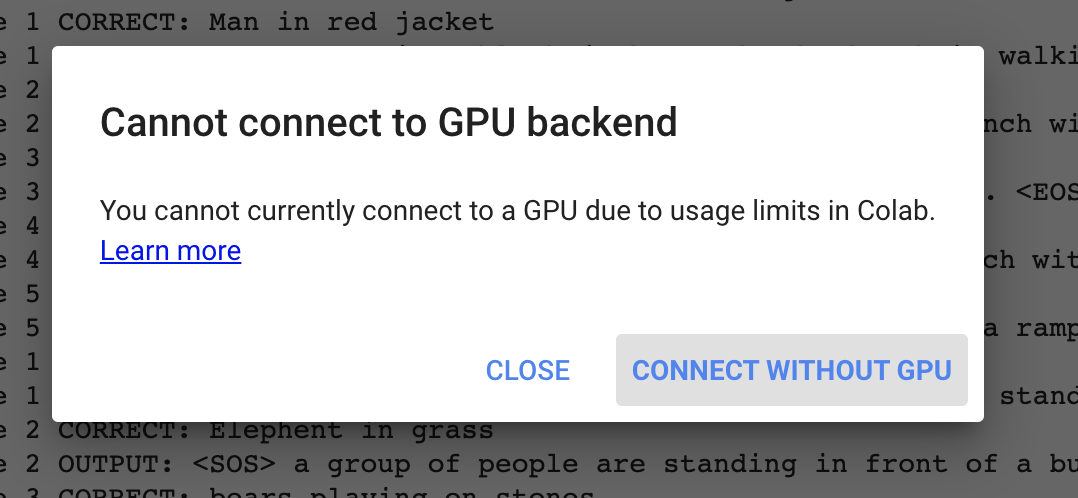